In [ ]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

PREDICT_FOLDER = "new_image/predict"
SHAPES_FOLDER = "new_image/predict_shapes"
COLORS_FOLDER = "new_image/predict_center_squares"

# clear ./new_image folder before processing (we want this folder to contain the object detection results for the current image only)
def clear_folder(folder_path):
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.remove(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')

# extract RGB color codes from an image
def extract_rgb_codes(image_path):
    # clear previous results
    clear_folder("new_image")

    model = YOLO("./trained_yolo8.pt")

    results = model.predict(
        source=image_path,
        save=True,
        conf=0.8,
        project="new_image",
        name="predict"
    )

    # create output folder for cropped objects
    os.makedirs(SHAPES_FOLDER, exist_ok=True)
    os.makedirs(COLORS_FOLDER, exist_ok=True)

    # original image
    image = cv2.imread(image_path)

    # extract objects from YOLO results
    for i, box in enumerate(results[0].boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # bounding box coordinates
        class_id = int(box.cls[0])  # class index
        class_name = model.names[class_id]  # class label

        # crop the detected object
        cropped_object = image[y1:y2, x1:x2]
        save_path = os.path.join(SHAPES_FOLDER, f"{class_name}_{i}.jpg")
        cv2.imwrite(save_path, cropped_object)

    # extract colors
    square_size = 20  # center square size
    extracted_colors = {}

    for img_path in os.listdir(SHAPES_FOLDER):
        if img_path.endswith(".jpg") and "color-calibration-tool" not in img_path:
            img = cv2.imread(os.path.join(SHAPES_FOLDER, img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            h, w, _ = img.shape
            center_x, center_y = w // 2, h // 2  # image center

            x1, y1 = max(center_x - square_size // 2, 0), max(center_y - square_size // 2, 0)
            x2, y2 = min(center_x + square_size // 2, w), min(center_y + square_size // 2, h)

            # crop the center square
            center_square = img[y1:y2, x1:x2]

            # save the cropped square
            tiny_square_path = os.path.join(COLORS_FOLDER, f"center_{img_path}")
            cv2.imwrite(tiny_square_path, cv2.cvtColor(center_square, cv2.COLOR_RGB2BGR))

            # compute average RGB color
            avg_color = np.mean(center_square, axis=(0, 1))
            extracted_colors[img_path] = avg_color

    # extract RGB values in the specified order
    ordered_keys = ["paint-color_1.jpg", "circle", "triangle", "pentagon"]
    rgb_list = []

    for key in ordered_keys:
        # find the correct filename in detected objects
        matching_file = next((k for k in extracted_colors.keys() if key in k), None)
        if matching_file:
            rgb_list.extend(extracted_colors[matching_file])
        else:
            rgb_list.extend([0, 0, 0])  # if missing, append black

    return rgb_list, extracted_colors  # returns both list and dict formats

# visualize the detection result
def visualize_detection(image_path):
    result_img_path = os.path.join(PREDICT_FOLDER, os.path.basename(image_path))

    image = cv2.imread(result_img_path)
    if image is None:
        print("Error: Detection result not found. Check path!")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# display the detected objects
def visualize_detected_objects():
    if not os.path.exists(SHAPES_FOLDER):
        print("Error: No detected objects found.")
        return

    cropped_images = [os.path.join(SHAPES_FOLDER, img) for img in os.listdir(SHAPES_FOLDER) if img.endswith(".jpg")]
    
    if not cropped_images:
        print("No objects detected.")
        return

    fig, axes = plt.subplots(1, len(cropped_images), figsize=(15, 5))

    for ax, img_path in zip(axes, cropped_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.set_title(os.path.basename(img_path))
        ax.axis("off")

    plt.show()

# visualize the extracted RGB colors
def visualize_extracted_colors(extracted_colors):
    if not extracted_colors:
        print("Error: No extracted colors found.")
        return

    # convert RGB values to 0-1 scale for Matplotlib
    normalized_colors = {name: np.array(color) / 255 for name, color in extracted_colors.items()}

    fig, axes = plt.subplots(1, len(normalized_colors), figsize=(10, 3))

    for i, (name, color) in enumerate(normalized_colors.items()):
        axes[i].imshow([[color]]) 
        axes[i].set_title(name, fontsize=10)
        axes[i].axis("off")

    plt.show()



image 1/1 /Users/nhile/brandeis/cosi149b/paint-color-detection/test_new_image/IMG_9112.jpg: 640x480 1 triangle, 1 circle, 1 pentagon, 1 color-calibration-tool, 1 paint-color, 39.7ms
Speed: 2.3ms preprocess, 39.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Results saved to new_image/predict
Extracted RGB Codes (List of 12 numbers): [194.965, 183.965, 165.965, 144.6275, 39.6275, 33.6275, 13.1775, 82.8875, 48.9875, 11.6775, 39.77, 92.4075]
Extracted RGB Codes (Dictionary): {'circle_2.jpg': array([     144.63,      39.627,      33.627]), 'triangle_4.jpg': array([     13.178,      82.888,      48.987]), 'paint-color_1.jpg': array([     194.97,      183.97,      165.97]), 'pentagon_0.jpg': array([     11.678,       39.77,      92.407])}


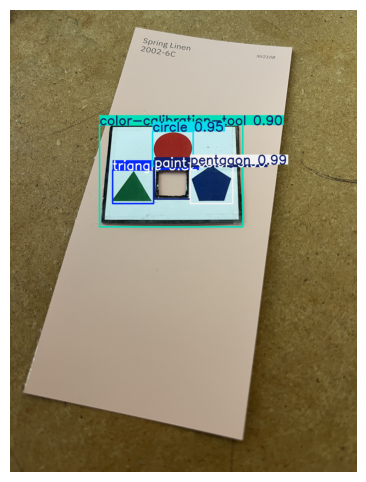

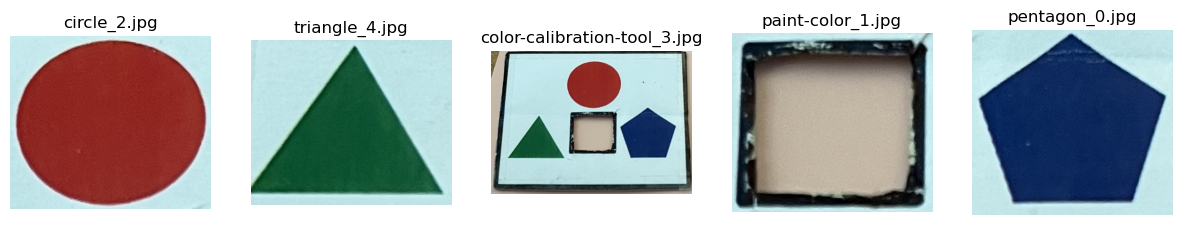

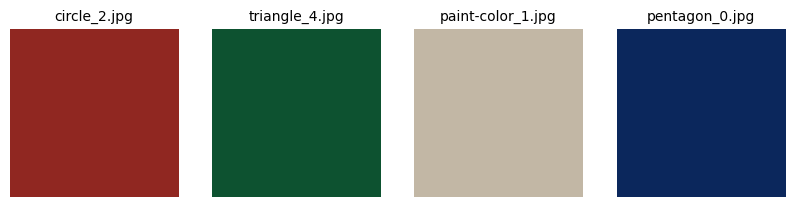

In [ ]:
image_path = "./test_new_image/IMG_9112.jpg"

rgb_list, rgb_dict = extract_rgb_codes(image_path)
# order: observed_R, observed_G, observed_B, red_R, red_G, red_B, green_R, green_G, green_B, blue_R, blue_G, blue_B
print("Extracted RGB Codes (List):", rgb_list)  
print("Extracted RGB Codes (Dictionary):", rgb_dict)

visualize_detection(image_path)
visualize_detected_objects()
visualize_extracted_colors(rgb_dict)

In [10]:
rgb_list

[194.965,
 183.965,
 165.965,
 144.6275,
 39.6275,
 33.6275,
 13.1775,
 82.8875,
 48.9875,
 11.6775,
 39.77,
 92.4075]

In [11]:
rgb_dict

{'circle_2.jpg': array([     144.63,      39.627,      33.627]),
 'triangle_4.jpg': array([     13.178,      82.888,      48.987]),
 'paint-color_1.jpg': array([     194.97,      183.97,      165.97]),
 'pentagon_0.jpg': array([     11.678,       39.77,      92.407])}